In [128]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from plsr.analysis import *

In [129]:
from curvefit import DatasetSpectra

In [130]:
from boxsers.preprocessing import rubberband_baseline_cor

In [131]:
file_path = '~/data/dataset_294.csv'
domain_path = '~/data/domain.csv'

# file_path = '~/data/dataset_565.csv'
# domain_path = '~/data/dataset_565_domain.csv'

<Axes: >

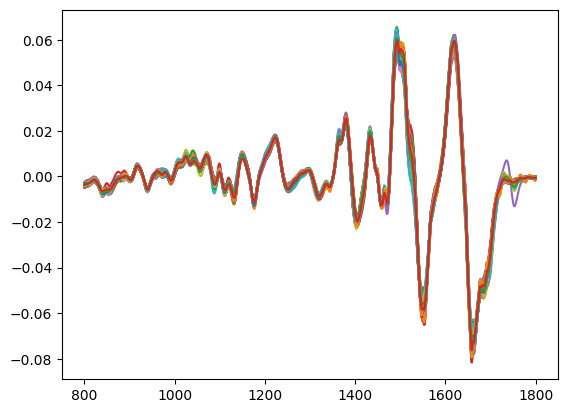

In [132]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_abs(0.3)
# dataset.baseline_corr()
dataset.savgol_filter(window_length=32, polyorder=2, deriv=1)
dataset.normalization(kind='vector')
dataset.select_region(800, 1800)
pd.DataFrame(dataset.spectra, columns=dataset.wavenumbers).T.plot(legend=False)

In [133]:
print(dataset.n_samples)

294


In [134]:
X = dataset.spectra
y = dataset.hba1c
# scaler = StandardScaler()
# y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

<Axes: ylabel='Count'>

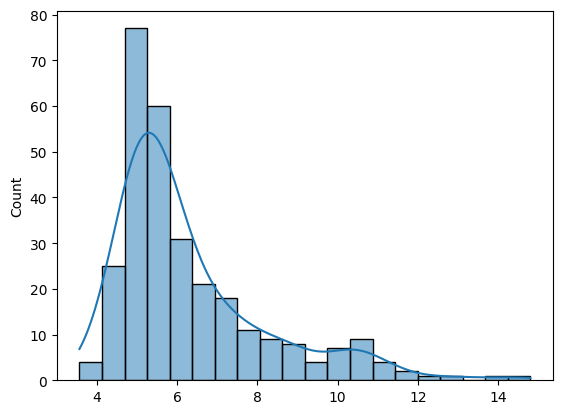

In [135]:
sns.histplot(y, kde=True)

In [136]:
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', subsample=None, random_state=4)
categories = discretizer.fit_transform(y.reshape(-1, 1))

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=categories, random_state=44)

Text(0.5, 0, 'HbA1c')

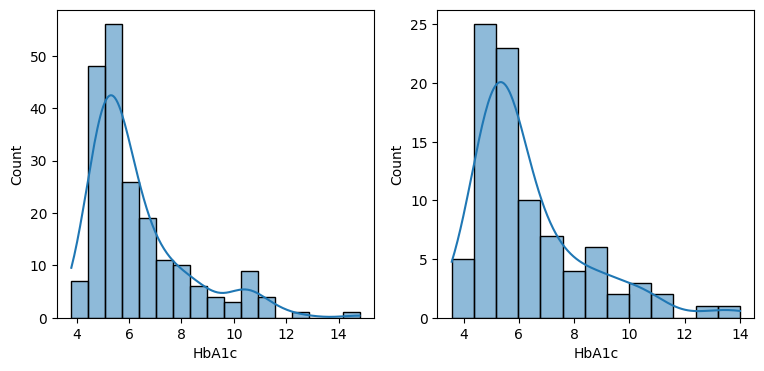

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(y_train, ax=axs[0], kde=True)
sns.histplot(y_test, ax=axs[1], kde=True)

axs[0].set_xlabel('HbA1c')
axs[1].set_xlabel('HbA1c')

┌──────────────────────────┐
│       FIT RESULTS        │
├──────────────────────────┤
│ RMSE = 1.0254            │
│ R2 = 0.6984              │
│ R = 0.8395               │
│ Number of components = 8 │
└──────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='y predicted', ylabel='Residuals'>]], dtype=object))

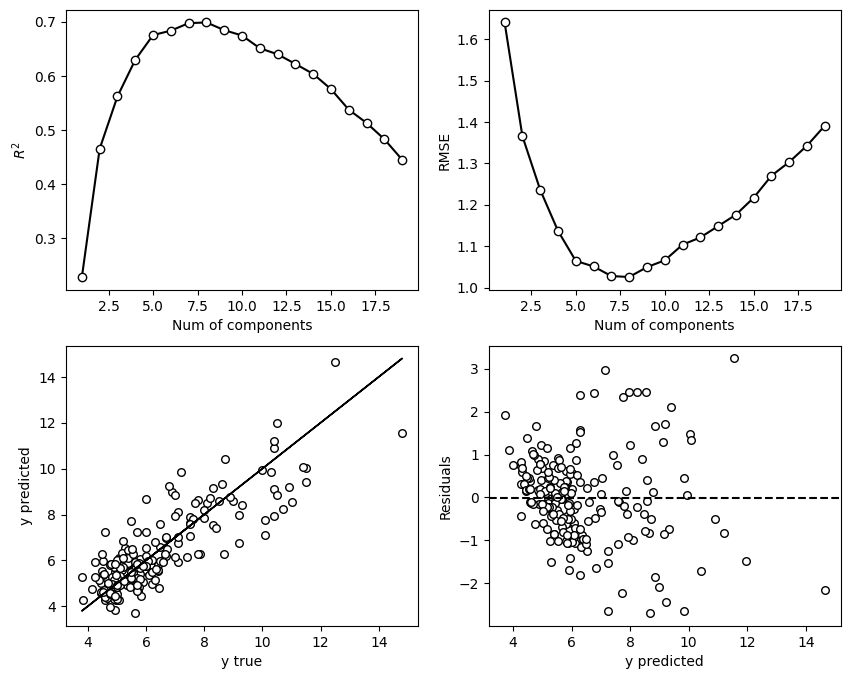

In [139]:
plot_number_components(X_train, y_train, number_range=(1, 20), cv=6)

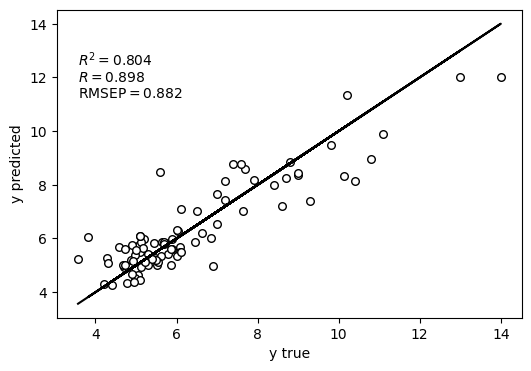

In [155]:
pls = PLSRegression(n_components=8, scale=False)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
fig, axs = plsr_r2_plot(y_test, y_pred)

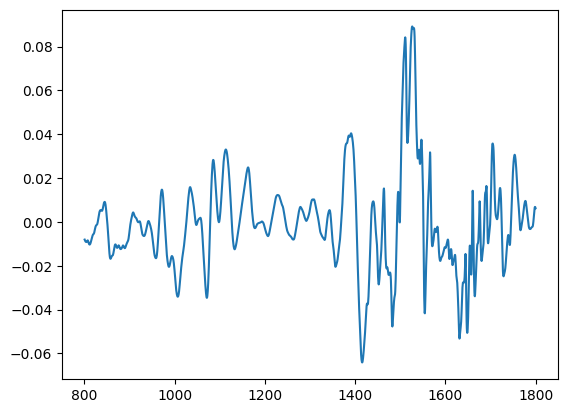

In [157]:
plt.plot(dataset.wavenumbers, pls.x_weights_[:, 0])

In [190]:
def explained_variance(model, y_train):
    r2_sum = 0
    for comp in range(0, model.n_components):
        y_pred = np.dot(model.x_scores_[:, comp].reshape(-1, 1), model.y_loadings_[:, comp].reshape(-1, 1).T) + y_train.mean(axis=0)
        r2_sum += round(r2_score(y_train, y_pred), 3)
        print('R2 for %d component: %g' %(comp + 1,round(r2_score(y_train, y_pred), 3)))
        print(f'R2 for all {comp + 1} components: {r2_sum}')
    
explained_variance(pls, y_train)

R2 for 1 component: 0.25
R2 for all 1 components: 0.25
R2 for 2 component: 0.249
R2 for all 2 components: 0.499
R2 for 3 component: 0.108
R2 for all 3 components: 0.607
R2 for 4 component: 0.069
R2 for all 4 components: 0.6759999999999999
R2 for 5 component: 0.057
R2 for all 5 components: 0.733
R2 for 6 component: 0.021
R2 for all 6 components: 0.754
R2 for 7 component: 0.028
R2 for all 7 components: 0.782
R2 for 8 component: 0.018
R2 for all 8 components: 0.8
